## Logging device states and test results to a database
Database logging in labbench database can automatically acquire instrument states from descriptors in any device's `state` attribute. Database managers in `labbench` also support dynamic generation of relational databases on the fly.

#### File formats
All labbench data save functionality is implemented in tables with [pandas](pandas.pydata.org) DataFrame backends. Here are the storage formats that are supported:

| Format                            | File extension(s)              | Master database manager | flag to [use record file format](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToRelationalTable.set_relational_file_format) | Comments |
|:----------------------------------|:-------------------------------|:-----------------------|:------------------------|:----
| [sqlite](sqlite.org)              | .db                            | [labbench.StatesToCSV](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToCSV) | 'sqlite' | Scales to larger master databases than csv |
| [feather](github.com/wesm/feather)| .f                             | Not supported | 'feather' | Python 3.x only
| csv                               | .csv,.csv.gz,.csv.bz2,.csv.zip | [labbench.StatesToSQLite](http://ssm.ipages.nist.gov/labbench/labbench.html#labbench.managedata.StatesToCSV)          |'csv'| Not recommended for master databases |
| [json](http://www.json.org/)      | .json                          | Not supported         | 'json' | |
| python [pickle](https://docs.python.org/3/library/pickle.html) | .pickle | Not supported | 'pickle' | "Type 2" for python version portability|

In the following example, we will use an sqlite master database, and csv record files. 

#### Example
Here is a emulated "dummy" instrument. It has a few state settings similar to a simple power sensor. The state descriptors (`initiate_continuous`, `output_trigger`, etc.) are defined as local types, which means they don't trigger communication with any actual devices. The `fetch_trace` method generates a "trace" drawn from a uniform distribution.

In [1]:
import sys
sys.path.insert(0,'..')
import labbench as lb
import numpy as np
import pandas as pd

class EmulatedInstrument(lb.EmulatedVISADevice):
    ''' This "instrument" makes mock data and instrument states to
        demonstrate we can show the process of setting
        up a measurement.
    '''
    class state (lb.Device.state):
        initiate_continuous = lb.LocalBool(default_value=True,command='INIT:CONT')
        output_trigger      = lb.LocalBool(default_value=False, command='OUTP:TRIG')
        sweep_aperture      = lb.LocalFloat(default_value=50e-6,min=20e-6, max=200e-3,help='s')
        frequency           = lb.LocalFloat(default_value=2.4e9,min=10e6, max=18e9,step=1e-3,help='Hz')

    def trigger(self):
        ''' This would tell the instrument to start a measurement
        '''
        pass
    
    def fetch_trace(self, N=1001):
        ''' Generate N points of junk data as a pandas series.
        '''
        values = np.random.normal(size=N)
        index = np.linspace(0,self.state.sweep_aperture,N)
        series = pd.Series(values,index=index,name='voltage')
        series.index.name = 'time'
        return series

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: metadata {'command': 'INIT:CONT'} was set from the constructor. With traitlets 4.1, metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  del sys.path[0]


Now make a loop to execute 100 test runs with two emulated instruments, and log the results with a relational SQLite database. I do a little setup to start:

1. Define a couple of functions `inst1_trace` and `inst2_trace` that collect my data
2. Instantiate 2 instruments, `inst1` and `inst2`
3. Instantiate the logger with `lb.RelationalDataInSQLite('test.db', 'state')`.
   The arguments specify the name of the sqlite database file and the name of the table where the following will be stored: 1) the instrument state info will be stored, 2) locations of data files, and 3) any extra comments we add with `db.write()`.
   
Remember that use of the `with` statement automatically connects to the instruments, and then ensures that the instruments are properly closed when we leave the `with` block (even if there is an exception).

In [2]:
def inst1_trace ():
    ''' Return a 1001-point trace
    '''
    inst1.trigger()
    return inst1.fetch_trace(51)

def inst2_trace ():
    ''' This one returns only one point
    '''
    inst2.trigger()
    return inst2.fetch_trace(1).values[0]
    
db_path = r'data/test.db'
data = {'dut': 'DUT 15'}
Nfreqs = 101

with EmulatedInstrument()        as inst1,\
     EmulatedInstrument()        as inst2,\
     lb.StatesToSQLite(db_path)  as db:         
        # Catch any changes in inst1.state and inst2.state
        db.observe([inst1,inst2])  
        
        # Update inst1.state.sweep_aperture on each db.append
        db.observe(inst1, always='sweep_aperture')
        
        # Store trace data in csv format
        db.set_relational_file_format('csv')
        
        # Perform a frequency sweep. The frequency will be logged to the
        # database, because we configured it to observe all state changes.
        inst2.state.frequency = 5.8e9
        for inst1.state.frequency in np.linspace(5.8e9, 5.9e9, Nfreqs):
            # Collect "test data" by concurrently calling
            # inst1_trace and inst2_trace
            data.update(lb.concurrently(inst1_trace, inst2_trace))

            # We can add custom metadata 
            db.append(comments='trying for 1.21 GW to time travel',
                      **data)

#### Reading and exploring the data
The master database is now populated with the test results and subdirectories are populated with trace data. `labbench` provides the function `read` as a shortcut to load the sqlite database into a pandas dataframe. Each state is a column in the database. The logger creates columns named as a combination of the device name ('inst1') and name of the corresponding device state.

In [3]:
%pylab inline
master = lb.read(db_path)
master.head()

Populating the interactive namespace from numpy and matplotlib


,comments,dut,inst1_frequency,inst1_sweep_aperture,inst1_trace,inst2_frequency,inst2_trace,time
id,,,,,,,,
0,trying for 1.21 GW to time travel,DUT 15,5.800000e+09,0.00005,data\0 2017-10-24 100546.088000\inst1_trace.csv,5.800000e+09,0.018684,2017-10-24 10:05:46.088
1,trying for 1.21 GW to time travel,DUT 15,5.801000e+09,0.00005,data\1 2017-10-24 100546.101000\inst1_trace.csv,5.800000e+09,-1.514335,2017-10-24 10:05:46.101
2,trying for 1.21 GW to time travel,DUT 15,5.802000e+09,0.00005,data\2 2017-10-24 100546.112000\inst1_trace.csv,5.800000e+09,-1.444044,2017-10-24 10:05:46.112
3,trying for 1.21 GW to time travel,DUT 15,5.803000e+09,0.00005,data\3 2017-10-24 100546.124000\inst1_trace.csv,5.800000e+09,-0.164416,2017-10-24 10:05:46.124
4,trying for 1.21 GW to time travel,DUT 15,5.804000e+09,0.00005,data\4 2017-10-24 100546.135000\inst1_trace.csv,5.800000e+09,-1.212521,2017-10-24 10:05:46.135


This is a pandas DataFrame object. There is extensive information about how to use dataframes [on the pandas website](http://pandas.pydata.org/pandas-docs/stable/). Suppose we want to bring in the data from the traces, which are in a collection of waveform files specified under the `inst1_trace` column. The function `labbench.expand` serves to flatten the database with respect to data files that were generated on each row.

In [4]:
waveforms = lb.expand(master, 'inst1_trace', ['dut', 'time', 'inst1_frequency'])
waveforms

,inst1_trace_time,inst1_trace_voltage,inst1_trace_id,dut,time,inst1_frequency
0,0.000000,0.585175,0,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
1,0.000001,-1.177598,1,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
2,0.000002,0.465873,2,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
3,0.000003,-0.934024,3,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
4,0.000004,0.139058,4,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
5,0.000005,1.127127,5,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
6,0.000006,-1.095337,6,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
7,0.000007,0.725842,7,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
8,0.000008,-0.155378,8,DUT 15,2017-10-24 10:05:46.088,5.800000e+09
9,0.000009,0.385878,9,DUT 15,2017-10-24 10:05:46.088,5.800000e+09


now we can manipulate the results to look for meaningful information in the data.

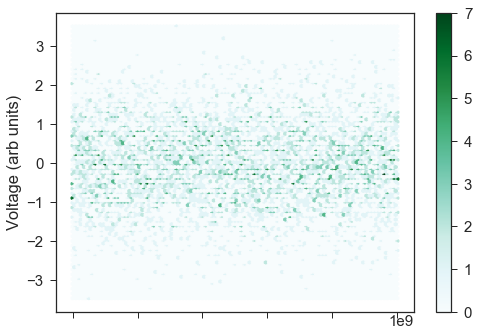

In [11]:
import seaborn as sns; sns.set(context='notebook', style='ticks', font_scale=1.5) # Theme stuff

waveforms.plot(x='inst1_frequency',y='inst1_trace_voltage',kind='hexbin')
xlabel('Frequency (Hz)')
ylabel('Voltage (arb units)')